In [1]:
import numpy as np
import pandas as pd
from utils.model_training import prepare_model_features, train_basic_cat_model, train_basic_LR_model
from sklearn.model_selection import train_test_split
import seaborn as sns



In [2]:
df = pd.read_csv(
    "./data/processed/stop-and-frisk.csv",
    parse_dates=["STOP_FRISK_DATE"],  
)
# df.info()

In [3]:
X, y = prepare_model_features(df)
assert not X.isnull().any().any(), "Null values remain in features"

In [4]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("Train distribution:", y_train.value_counts(normalize=True), "\n")
print("Test distribution:", y_test.value_counts(normalize=True))

Train distribution: OFFICER_USED_FORCE
False    0.748507
True     0.251493
Name: proportion, dtype: float64 

Test distribution: OFFICER_USED_FORCE
False    0.748501
True     0.251499
Name: proportion, dtype: float64


In [5]:
print("These are all the training features")
X.columns

These are all the training features


Index(['SUSPECT_REPORTED_AGE', 'SUSPECT_HEIGHT', 'HOUR_OF_DAY',
       'BOROUGH_FORCE_RATE', 'NEIGHBORHOOD_FORCE_RATE',
       'SUSPECT_RACE_DESCRIPTION_ASIAN / PACIFIC ISLANDER',
       'SUSPECT_RACE_DESCRIPTION_BLACK',
       'SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC',
       'SUSPECT_RACE_DESCRIPTION_MIDDLE EASTERN/SOUTHWEST ASIAN',
       'SUSPECT_RACE_DESCRIPTION_WHITE',
       'SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC', 'SUSPECT_SEX_MALE',
       'STOP_WAS_INITIATED_Based on Radio Run',
       'STOP_WAS_INITIATED_Based on Self Initiated',
       'OFFICER_EXPERIENCE_senior', 'AGE_GROUP_teen', 'AGE_GROUP_young_adult',
       'AGE_GROUP_adult', 'AGE_GROUP_senior', 'OFFICER_IN_UNIFORM_FLAG',
       'IS_NIGHT', 'IS_WEEKEND', 'IS_CHILD',
       'SUSPECTED_CRIME_DESCRIPTION_ENCODED',
       'STOP_LOCATION_BORO_NAME_ENCODED', 'NEIGHBORHOOD_ENCODED'],
      dtype='object')

### Trial and Error: An Unsupervised Story
So diving into the unsupervised modeling, I will be using K-means clustering as well as PCA dimensionality reduction to find latent features in the dataset.

I tried a number of different combinations of features, but ultimately decided to pull the SHAP features out of my CatBoost model given it was the most algorithmically relevant set of features rather than me projecting my own biases on the dataset.

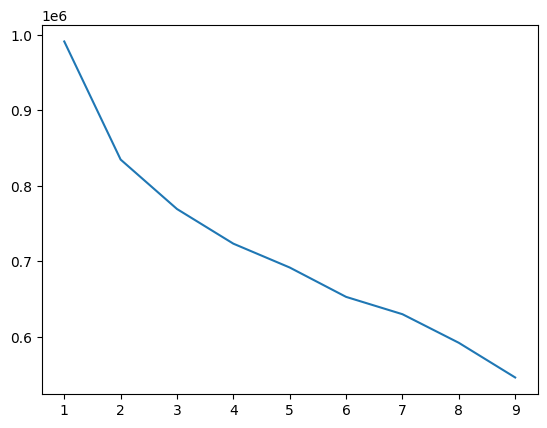

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Todo: move to EDA

# Focus on demographic features
# demo_features = ['SUSPECT_REPORTED_AGE', 'SUSPECT_HEIGHT',
#                 'NEIGHBORHOOD_ENCODED', 'SUSPECT_RACE_DESCRIPTION_ENCODED']

PCA_features = [
    "SUSPECT_REPORTED_AGE",
    "SUSPECT_HEIGHT",
    "BOROUGH_FORCE_RATE",  # More policy-relevant than neighborhood
    "STOP_WAS_INITIATED_Based on Self Initiated",  # Key behavioral marker
    # 'SUSPECT_RACE_DESCRIPTION_BLACK',
]

# Primary clustering features
primary_features = [
    "SUSPECTED_CRIME_DESCRIPTION_ENCODED",
    "NEIGHBORHOOD_ENCODED" "STOP_WAS_INITIATED_Based on Self Initiated",
    "BOROUGH_FORCE_RATE",
    "NEIGHBORHOOD_FORCE_RATE",
    "STOP_LOCATION_BORO_NAME_ENCODED",
]

# Secondary features to add
secondary_features = [
    "SUSPECT_SEX_MALE",
    "OFFICER_EXPERIENCE_senior",
    "IS_NIGHT",
    "IS_WEEKEND",
]

# Starting features
recommended_features = [
    "SUSPECT_REPORTED_AGE",
    "HOUR_OF_DAY",
    "BOROUGH_FORCE_RATE",
    "SUSPECTED_CRIME_DESCRIPTION_ENCODED",
    "NEIGHBORHOOD_ENCODED",
    "SUSPECT_SEX_MALE",
    "OFFICER_EXPERIENCE_senior",
    "IS_NIGHT",
    "IS_WEEKEND",
]

shap_features = [
    "SUSPECTED_CRIME_DESCRIPTION_ENCODED",
    "SUSPECT_REPORTED_AGE",
    "NEIGHBORHOOD_ENCODED",
    "HOUR_OF_DAY",
    "NEIGHBORHOOD_FORCE_RATE",
    "STOP_WAS_INITIATED_Based on Self Initiated",
    "SUSPECT_HEIGHT",
    "OFFICER_EXPERIENCE_senior",
    "STOP_WAS_INITIATED_Based on Radio Run",
    "BOROUGH_FORCE_RATE",
    "STOP_LOCATION_BORO_NAME_ENCODED",
    "SUSPECT_SEX_MALE",
    "SUSPECT_RACE_DESCRIPTION_BLACK",
    "AGE_GROUP_young_adult",
    "SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC",
    "OFFICER_IN_UNIFORM_FLAG",
    "SUSPECT_RACE_DESCRIPTION_WHITE",
    "AGE_GROUP_adult",
]

PCA_features = shap_features

scaler = StandardScaler()
X_scaled_selected_features = scaler.fit_transform(X[PCA_features])
X_full_scaled = scaler.fit_transform(X)
# Elbow method to find optimal clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled_selected_features)
    inertia.append(kmeans.inertia_)

# Plot elbow curve to choose K
plt.plot(range(1, 10), inertia)

### If the K-means fits...
Judging from this graph, we should technically choose 2 clusters, but I'm choosing to override this a bit.  After experimenting with up to 5, I determined that 4 clusters is "optimal" for the remainder of this analysis.

In [7]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X_scaled_selected_features)
kmeans_full = KMeans(n_clusters=4, random_state=42).fit(X_full_scaled)

# Create new DF with clusters
cluster_df = pd.DataFrame(X_scaled_selected_features, columns=PCA_features)
cluster_df['Cluster'] = kmeans.labels_  
cluster_df_full = pd.DataFrame(X_full_scaled)
cluster_df_full['Cluster'] = kmeans.labels_  

# Ensure that the distribution between clusters is reasonably balanced
print(pd.Series(kmeans.labels_).value_counts())
print(pd.Series(kmeans_full.labels_).value_counts())

3    16555
2    13031
1    12912
0    12549
Name: count, dtype: int64
2    16682
0    14912
1    12608
3    10845
Name: count, dtype: int64


After selecting 5 clusters initally, it looks like we can safely move things down to 4 for a more optimal balance between clusters.

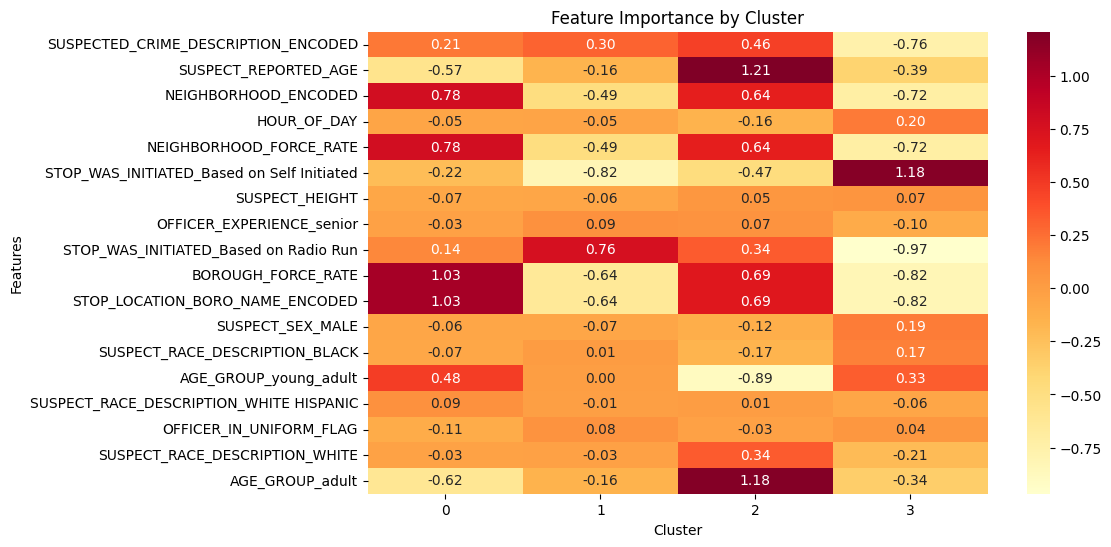

In [8]:
# Calculate mean values per cluster
def show_cluster_heatmap(df):
    cluster_means = df.groupby('Cluster').mean()

    plt.figure(figsize=(10,6))
    sns.heatmap(cluster_means.T, 
                cmap='YlOrRd', 
                annot=True, 
                fmt='.2f')
    plt.title('Feature Importance by Cluster')
    plt.ylabel('Features')
    plt.xlabel('Cluster')
show_cluster_heatmap(cluster_df)

### A Clustered Heat Map
I won't go into too much detail here given I will dive in more thoroughly later, but we can begin to see the formation of new latent features.  Assuming that the random_state holds for subsequent runs and the cluster numbering stays consistent...

- Cluster 0: Borough and neighborhood force rate and black youth
- Cluster 1: Community and/or witness initiated events
- Cluster 2: Borough and neighborhood force rate leading to events with adults
- Cluster 3: Officer initiated stops of black youth


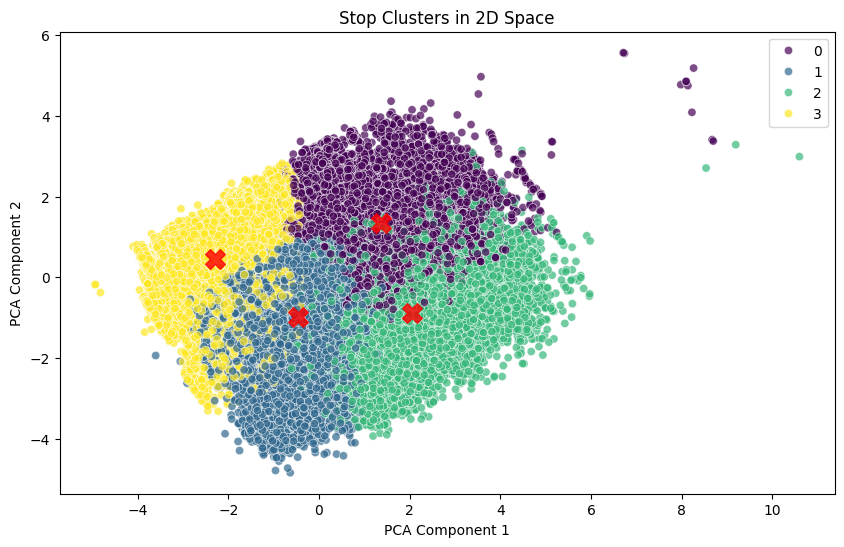

In [9]:
from sklearn.decomposition import PCA
def plot_PCA(X):
    # Reduce to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot with cluster labels
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], 
                    hue=kmeans.labels_, 
                    palette='viridis',
                    alpha=0.7)
    plt.title('Stop Clusters in 2D Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    # Add cluster centers
    centers_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_pca[:,0], centers_pca[:,1], 
                c='red', s=200, alpha=0.8, marker='X')
plot_PCA(X_scaled_selected_features)

Good separation of clusters at 4 nodes vs 5 in which the 5th cluster's data points were scattered over the entire dataset.

In [10]:
# Temp
# Calculate racial composition per cluster
post_cluster_df = pd.DataFrame(X)
post_cluster_df['Cluster'] = kmeans.labels_  
# post_cluster_df.columns
race_pcts = (post_cluster_df.groupby('Cluster')['SUSPECT_RACE_DESCRIPTION_BLACK']
             .mean()
             .sort_values(ascending=False))

print(f"Cluster Racial Composition:\n{race_pcts}")

Cluster Racial Composition:
Cluster
3    0.684687
1    0.606103
0    0.564188
2    0.517765
Name: SUSPECT_RACE_DESCRIPTION_BLACK, dtype: float64


In [11]:
# Compare variance explained by your 4 features vs. full dataset
pca_full = PCA().fit(X_full_scaled)  
pca_subset = PCA().fit(X_scaled_selected_features)
print("Full dataset variance:", pca_full.explained_variance_ratio_.cumsum()[:4])
print("Your features' variance:", pca_subset.explained_variance_ratio_.cumsum())

Full dataset variance: [0.1689348  0.27119921 0.35104552 0.42070385]
Your features' variance: [0.22953833 0.34353198 0.43586521 0.51806308 0.58310996 0.64303981
 0.70125773 0.75590589 0.80700311 0.85113069 0.88735539 0.92188158
 0.95518945 0.97656086 0.98934937 1.         1.         1.        ]


In [12]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Your top SHAP features
top_features = [
    'SUSPECTED_CRIME_DESCRIPTION_ENCODED',
    'SUSPECT_REPORTED_AGE', 
    'NEIGHBORHOOD_ENCODED',
    'HOUR_OF_DAY',
    'NEIGHBORHOOD_FORCE_RATE',
    'STOP_WAS_INITIATED_Based on Self Initiated',
    'SUSPECT_HEIGHT',
    'OFFICER_EXPERIENCE_senior',
    'STOP_WAS_INITIATED_Based on Radio Run',
    'BOROUGH_FORCE_RATE',
    'STOP_LOCATION_BORO_NAME_ENCODED',
    'SUSPECT_SEX_MALE'
]

# Demographic features for bias analysis
demographic_features = [
    'SUSPECT_RACE_DESCRIPTION_BLACK',
    'SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC',
    'SUSPECT_RACE_DESCRIPTION_WHITE',
    'SUSPECT_SEX_MALE',
    'SUSPECT_REPORTED_AGE'
]

def perform_pca_analysis(df, features, n_components=None):
    """
    Perform PCA analysis with comprehensive output
    """
    # Handle missing values
    df_clean = df[features].fillna(df[features].median())
    
    # Determine number of components if not specified
    if n_components is None:
        n_components = min(len(features), 10)
    
    # Create PCA pipeline with scaling
    pca_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components))
    ])
    
    # Fit and transform
    pca_components = pca_pipeline.fit_transform(df_clean)
    pca = pca_pipeline.named_steps['pca']
    
    # Create results dataframe
    pca_df = pd.DataFrame(
        pca_components, 
        columns=[f'PC{i+1}' for i in range(n_components)]
    )
    
    return pca_df, pca, pca_pipeline

def analyze_component_loadings(pca, features, n_components=5):
    """
    Analyze and visualize PCA loadings
    """
    # Get loadings (components)
    loadings = pca.components_[:n_components]
    
    # Create loadings dataframe
    loadings_df = pd.DataFrame(
        loadings.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=features
    )
    
    print("Top Feature Loadings by Component:")
    print("=" * 50)
    
    for i in range(n_components):
        pc_name = f'PC{i+1}'
        print(f"\n{pc_name} (Variance Explained: {pca.explained_variance_ratio_[i]:.3f}):")
        
        # Get top positive and negative loadings
        pc_loadings = loadings_df[pc_name].abs().sort_values(ascending=False)
        print("Top contributing features:")
        for feature, loading in pc_loadings.head(5).items():
            actual_loading = loadings_df.loc[feature, pc_name]
            print(f"  {feature}: {actual_loading:.3f}")
    
    return loadings_df

def analyze_demographic_correlations(pca_df, df, demographic_features):
    """
    Analyze how PCA components correlate with demographic variables
    """
    print("\nDemographic Correlations with Principal Components:")
    print("=" * 60)
    
    correlations = {}
    
    for demo_feature in demographic_features:
        if demo_feature in df.columns:
            correlations[demo_feature] = {}
            
            for pc in pca_df.columns:
                corr, p_value = pearsonr(pca_df[pc], df[demo_feature])
                correlations[demo_feature][pc] = {'correlation': corr, 'p_value': p_value}
                
                if abs(corr) > 0.1:  # Only show meaningful correlations
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                    print(f"{demo_feature} vs {pc}: r={corr:.3f} {significance}")
    
    return correlations

def plot_pca_results(pca, pca_df, loadings_df):
    """
    Create visualizations for PCA results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Explained variance
    axes[0,0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
                  pca.explained_variance_ratio_)
    axes[0,0].set_xlabel('Principal Component')
    axes[0,0].set_ylabel('Explained Variance Ratio')
    axes[0,0].set_title('Explained Variance by Component')
    
    # 2. Cumulative explained variance
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    axes[0,1].plot(range(1, len(cumvar) + 1), cumvar, 'bo-')
    axes[0,1].axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
    axes[0,1].set_xlabel('Number of Components')
    axes[0,1].set_ylabel('Cumulative Explained Variance')
    axes[0,1].set_title('Cumulative Explained Variance')
    axes[0,1].legend()
    
    # 3. PC1 vs PC2 scatter
    axes[1,0].scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6)
    axes[1,0].set_xlabel('PC1')
    axes[1,0].set_ylabel('PC2')
    axes[1,0].set_title('PC1 vs PC2 Scatter Plot')
    
    # 4. Loadings heatmap (top 5 components)
    n_components_plot = min(5, loadings_df.shape[1])
    sns.heatmap(loadings_df.iloc[:, :n_components_plot], 
                annot=True, cmap='RdBu_r', center=0, ax=axes[1,1])
    axes[1,1].set_title('Feature Loadings Heatmap')
    
    plt.tight_layout()
    plt.show()

# Main analysis function
def run_complete_pca_analysis(df, top_features=PCA_features):
    """
    Run complete PCA analysis workflow
    """
    print("Starting PCA Analysis on Stop-and-Frisk Dataset")
    print("=" * 60)
    
    # Perform PCA
    pca_df, pca, pca_pipeline = perform_pca_analysis(df, top_features)
    
    print(f"PCA completed. Shape: {pca_df.shape}")
    print(f"Total variance explained by {len(pca_df.columns)} components: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Analyze loadings
    loadings_df = analyze_component_loadings(pca, top_features)
    
    # Analyze demographic correlations
    demo_correlations = analyze_demographic_correlations(pca_df, df, demographic_features)
    
    # Create visualizations
    plot_pca_results(pca, pca_df, loadings_df)
    
    return pca_df, pca, loadings_df, demo_correlations

# Usage example:
# Assuming your dataframe is called 'df'
# pca_results, pca_model, loadings, correlations = run_complete_pca_analysis(df)

# Additional analysis: Find stops with extreme PC scores
def find_extreme_cases(pca_df, df, percentile=95):
    """
    Find cases with extreme principal component scores
    """
    print(f"\nExtreme Cases (>{percentile}th percentile):")
    print("=" * 40)
    
    for pc in pca_df.columns[:3]:  # Top 3 components
        threshold = np.percentile(pca_df[pc], percentile)
        extreme_indices = pca_df[pca_df[pc] > threshold].index
        
        print(f"\n{pc} extreme cases ({len(extreme_indices)} cases):")
        if len(extreme_indices) > 0:
            # Show characteristics of extreme cases
            extreme_demographics = df.loc[extreme_indices, demographic_features].mean()
            print("Average demographics of extreme cases:")
            for demo, value in extreme_demographics.items():
                print(f"  {demo}: {value:.3f}")

# find_extreme_cases(pca_results, df)

Starting PCA Analysis on Stop-and-Frisk Dataset
PCA completed. Shape: (55047, 10)
Total variance explained by 10 components: 0.851
Top Feature Loadings by Component:

PC1 (Variance Explained: 0.230):
Top contributing features:
  NEIGHBORHOOD_FORCE_RATE: 0.411
  NEIGHBORHOOD_ENCODED: 0.411
  BOROUGH_FORCE_RATE: 0.405
  STOP_LOCATION_BORO_NAME_ENCODED: 0.405
  STOP_WAS_INITIATED_Based on Self Initiated: -0.299

PC2 (Variance Explained: 0.114):
Top contributing features:
  AGE_GROUP_adult: -0.383
  SUSPECT_REPORTED_AGE: -0.325
  AGE_GROUP_young_adult: 0.323
  SUSPECT_RACE_DESCRIPTION_BLACK: 0.287
  STOP_WAS_INITIATED_Based on Self Initiated: 0.283

PC3 (Variance Explained: 0.092):
Top contributing features:
  SUSPECT_RACE_DESCRIPTION_BLACK: -0.580
  SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 0.567
  AGE_GROUP_adult: -0.300
  AGE_GROUP_young_adult: 0.297
  SUSPECT_HEIGHT: -0.262

PC4 (Variance Explained: 0.082):
Top contributing features:
  STOP_WAS_INITIATED_Based on Radio Run: -0.486
  STO

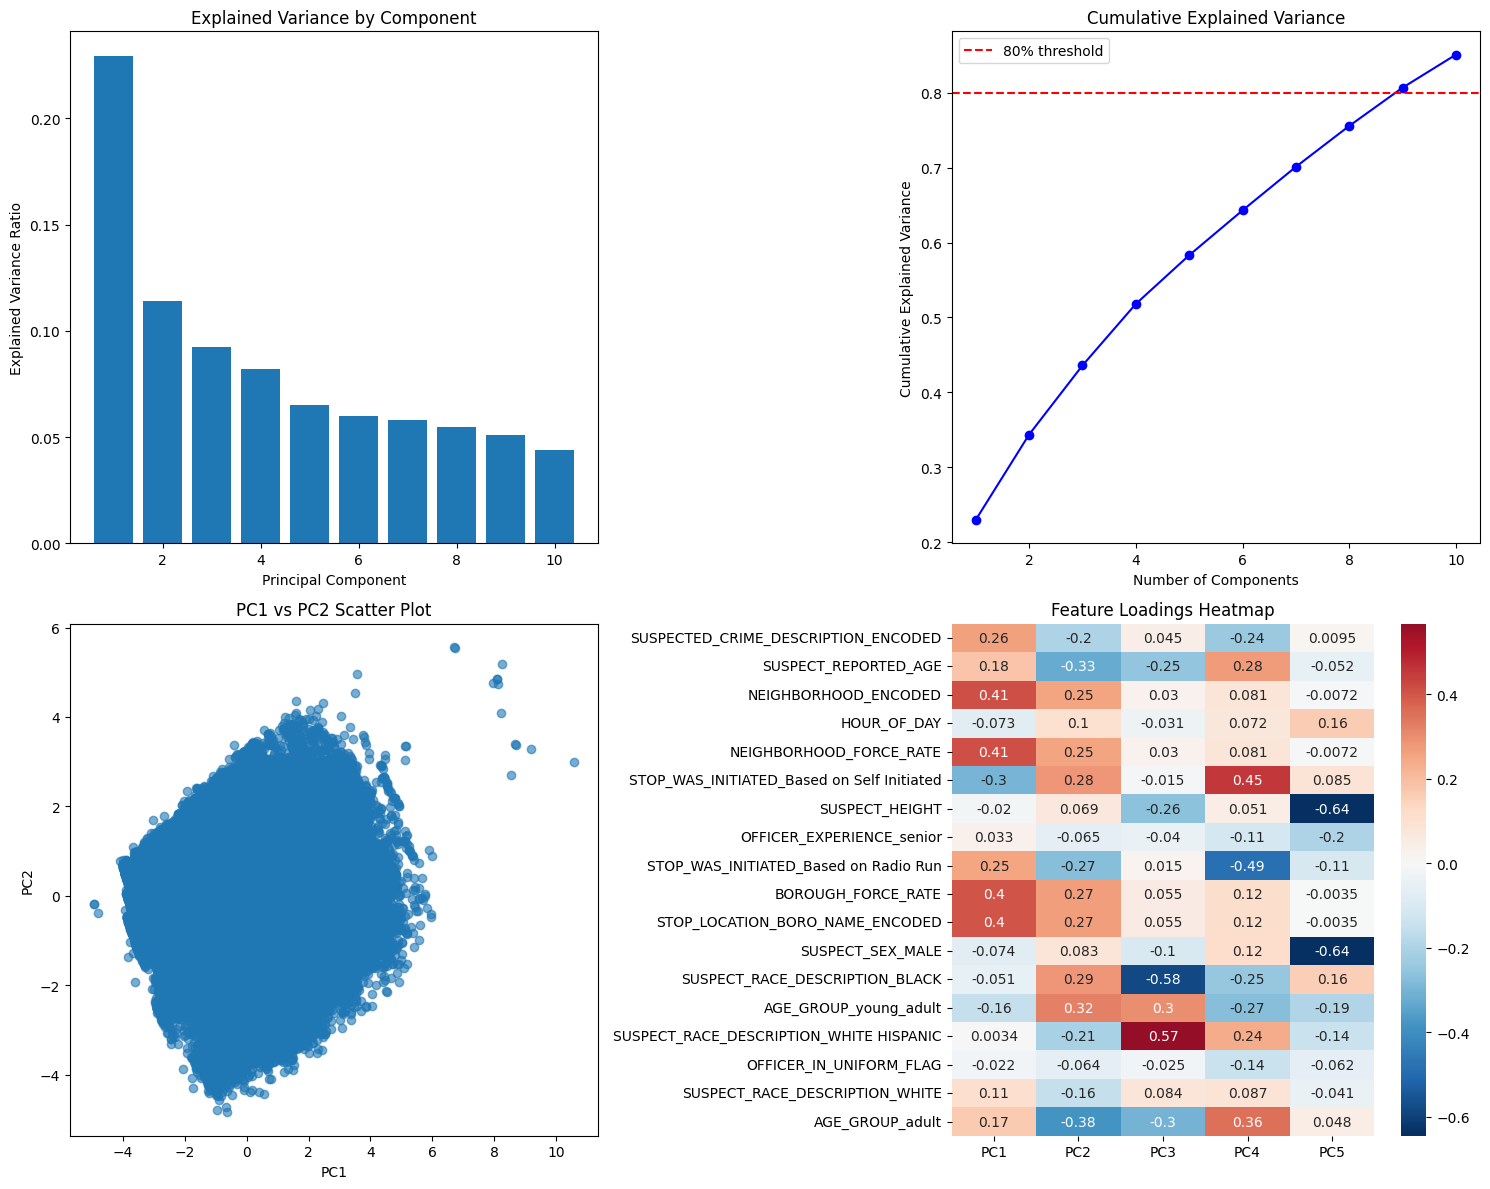

In [13]:
pca_results, pca_model, loadings, correlations = run_complete_pca_analysis(X)

# PC1, Location/Neighborhood, negative self initiated indicates radio/witness origin
# PC2, black males in targeted in a police initiated stop
# PC3, Young hispanic males, filtering out black males
# PC4, police initated stops of adults 
# PC5, shorter individuals and women, with small effect on time of day

### A PCA breakdown
I think the raw numbers below actually tell a better story in some ways, but we can see that the various PCA components after the first have relatively similar values at half the relative variance of the first component.

Similarly, we begin to see strong correlations in the various components.  In particular
- Component 1: Location
- Component 2: Location and young black males
- Component 3: Events targeting hispanic people
- Component 4: Officer initiated stops of hispanic individuals
- Component 5: Time of day events targetting women

In [14]:
find_extreme_cases(pca_results, X)
# demographic_features


Extreme Cases (>95th percentile):

PC1 extreme cases (2753 cases):
Average demographics of extreme cases:
  SUSPECT_RACE_DESCRIPTION_BLACK: 0.481
  SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 0.199
  SUSPECT_RACE_DESCRIPTION_WHITE: 0.206
  SUSPECT_SEX_MALE: 0.845
  SUSPECT_REPORTED_AGE: 39.462

PC2 extreme cases (2753 cases):
Average demographics of extreme cases:
  SUSPECT_RACE_DESCRIPTION_BLACK: 0.919
  SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 0.026
  SUSPECT_RACE_DESCRIPTION_WHITE: 0.006
  SUSPECT_SEX_MALE: 0.973
  SUSPECT_REPORTED_AGE: 22.173

PC3 extreme cases (2753 cases):
Average demographics of extreme cases:
  SUSPECT_RACE_DESCRIPTION_BLACK: 0.000
  SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 0.999
  SUSPECT_RACE_DESCRIPTION_WHITE: 0.001
  SUSPECT_SEX_MALE: 0.818
  SUSPECT_REPORTED_AGE: 22.879


### An incomplete endeavor
I briefly attempt to retrain by supervised learning models here, but simply ran out of time to improve them.

In [15]:
pca_df = df.copy()
pca_X, pca_y = prepare_model_features(pca_df)
pca_X['Cluster'] = kmeans.labels_  

clustered_X_train, clustered_X_test, clustered_y_train, clustered_y_test = train_test_split(pca_X, pca_y, test_size=0.2, random_state=42, stratify=y)
train_basic_LR_model(clustered_X_train, clustered_y_train, clustered_X_test, clustered_y_test)

[[4906 3335]
 [1075 1694]]
              precision    recall  f1-score   support

       False       0.82      0.60      0.69      8241
        True       0.34      0.61      0.43      2769

    accuracy                           0.60     11010
   macro avg       0.58      0.60      0.56     11010
weighted avg       0.70      0.60      0.63     11010

Top Features:
NEIGHBORHOOD_ENCODED: 0.3026
STOP_WAS_INITIATED_Based on Self Initiated: 0.2025
SUSPECTED_CRIME_DESCRIPTION_ENCODED: 0.1888
STOP_WAS_INITIATED_Based on Radio Run: 0.0606
SUSPECT_HEIGHT: 0.0552
AGE_GROUP_adult: 0.0507
OFFICER_EXPERIENCE_senior: 0.0477
SUSPECT_REPORTED_AGE: 0.0375
SUSPECT_SEX_MALE: 0.0364
SUSPECT_RACE_DESCRIPTION_BLACK: 0.0351
SUSPECT_RACE_DESCRIPTION_WHITE: 0.0279
Cluster: 0.0200
NEIGHBORHOOD_FORCE_RATE: 0.0199
AGE_GROUP_young_adult: 0.0174
OFFICER_IN_UNIFORM_FLAG: 0.0164
SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 0.0017
IS_NIGHT: 0.0000
IS_WEEKEND: 0.0000
IS_CHILD: 0.0000
AGE_GROUP_teen: 0.0000
SUSPECT_RACE_DE

### LR model doesn't improve
Judging from the model co-efficients, the addition of cluster data doesn't improve the model.

In [16]:
# Temp 
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

def train_basic_cat_model_temp(X_train, y_train, X_test, y_test):
        
    cat_model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.01,
        l2_leaf_reg=5,           # Increase regularization
        depth=10,
        loss_function='Logloss',
        # eval_metric='AUC', # To tightly fit the minority class/optimize recall
        scale_pos_weight=3,  # Balances positive class
        verbose=0,
        random_seed=42,
        eval_metric='F1',        # Monitor F1 during training
        early_stopping_rounds=50,
        # verbose=100
    )


    cat_model.fit(X_train, y_train)
    y_proba = cat_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Evaluate
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Get feature importances and names
    feature_importances = cat_model.get_feature_importance()
    feature_names = X_train.columns

    # Sort features by importance (descending)
    sorted_idx = np.argsort(feature_importances)[::-1]  # [::-1] reverses for descending
    sorted_features = feature_names[sorted_idx]
    sorted_importances = feature_importances[sorted_idx]

    print("Top Features:")
    for feat, imp in zip(sorted_features, sorted_importances):
        print(f"{feat}: {imp:.4f}")
    return cat_model
train_basic_cat_model_temp(clustered_X_train, clustered_y_train, clustered_X_test, clustered_y_test)

[[5205 3036]
 [1057 1712]]
              precision    recall  f1-score   support

       False       0.83      0.63      0.72      8241
        True       0.36      0.62      0.46      2769

    accuracy                           0.63     11010
   macro avg       0.60      0.62      0.59     11010
weighted avg       0.71      0.63      0.65     11010

Top Features:
HOUR_OF_DAY: 11.4940
SUSPECTED_CRIME_DESCRIPTION_ENCODED: 11.4476
NEIGHBORHOOD_FORCE_RATE: 7.9833
SUSPECT_REPORTED_AGE: 7.1947
SUSPECT_HEIGHT: 6.9946
NEIGHBORHOOD_ENCODED: 6.6016
OFFICER_EXPERIENCE_senior: 6.0388
STOP_LOCATION_BORO_NAME_ENCODED: 5.0239
Cluster: 4.6221
BOROUGH_FORCE_RATE: 4.5535
STOP_WAS_INITIATED_Based on Self Initiated: 4.0181
IS_WEEKEND: 3.2415
STOP_WAS_INITIATED_Based on Radio Run: 3.2002
SUSPECT_RACE_DESCRIPTION_BLACK: 2.9803
AGE_GROUP_young_adult: 2.0328
SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 1.8913
SUSPECT_SEX_MALE: 1.7808
AGE_GROUP_adult: 1.7434
AGE_GROUP_teen: 1.5577
SUSPECT_RACE_DESCRIPTION_WHITE:

## Augmentation improves performance, but only marginally
Simply concatenating the PCA cluster information to the initial training dataframe before training yields better results for the CatBoost, but not markedly so.  No real difference was detect with the logistic regression model.

That said, cluster does seem have strong predictive power in the model thus far.

In [17]:
train_basic_cat_model(clustered_X_train, clustered_y_train, clustered_X_test, clustered_y_test)

[[1604 6637]
 [ 146 2623]]
              precision    recall  f1-score   support

       False       0.92      0.19      0.32      8241
        True       0.28      0.95      0.44      2769

    accuracy                           0.38     11010
   macro avg       0.60      0.57      0.38     11010
weighted avg       0.76      0.38      0.35     11010

Top Features:
SUSPECT_REPORTED_AGE: 13.6173
SUSPECTED_CRIME_DESCRIPTION_ENCODED: 13.4501
NEIGHBORHOOD_FORCE_RATE: 10.8676
HOUR_OF_DAY: 9.6659
NEIGHBORHOOD_ENCODED: 8.8573
SUSPECT_HEIGHT: 6.3882
STOP_WAS_INITIATED_Based on Self Initiated: 6.1506
Cluster: 4.8246
OFFICER_EXPERIENCE_senior: 3.7055
STOP_WAS_INITIATED_Based on Radio Run: 2.7824
BOROUGH_FORCE_RATE: 2.6219
STOP_LOCATION_BORO_NAME_ENCODED: 2.5461
SUSPECT_RACE_DESCRIPTION_BLACK: 1.8352
SUSPECT_SEX_MALE: 1.6742
SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 1.3253
AGE_GROUP_young_adult: 1.2568
SUSPECT_RACE_DESCRIPTION_WHITE: 1.1569
OFFICER_IN_UNIFORM_FLAG: 1.0994
AGE_GROUP_teen: 1.0655
IS

# In Conclusion
To be continued... 

That said, as it is now, the unsupervised learning portion is relatively complete, but I am working to retrain my supervised learning models to determine how well I can improve their performance and generalization.

That said, its pretty clear that while location and the source of initiation of the incident are the most predictively powerful features, they contain a great deal of correlated bias for age, race, and gender.  